## Задача 1.3
Проверить мощность и консервативность критерия Уликоксона о равенстве медиан для выборок вида:

$X_1: ~ \alpha \cdot \mathcal{N}(0,1) + (1-\alpha) \cdot \mathcal{N}(2, 4)$;

$X_2: ~ \alpha \cdot \mathcal{N}(0,1) + (1-\alpha) \cdot \mathcal{N}(2, 4) + \delta$.

Здесь $\delta~-~$ сдвиг, дающий возможность разделить выборки $X_1$ и $X_2$.


Изучить зависимость от $\alpha$ и $\delta$.

**Важно:** распределение является гауссовой смесью, это не сумма гауссовых величин [пример как сэмплировать](https://stackoverflow.com/questions/49106806/how-to-do-a-simple-gaussian-mixture-sampling-and-pdf-plotting-with-numpy-scipy)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import pandas as pd
import seaborn as sns
import statsmodels
from tqdm import tqdm
text_size = 15
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = text_size
plt.rcParams['ytick.labelsize'] = text_size
plt.rcParams['legend.fontsize'] = text_size
plt.rcParams['axes.titlesize'] = text_size
plt.rcParams['axes.labelsize'] = text_size
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = text_size

Будем исследовать критерий Уликоксона о равенстве медиан.

$\Rightarrow$ $H_0: med(X_1) = med(X_2)$

$~~~~~H_1: med(X_1) \neq med(X_2)$

Мощность $W = \mathbb{P}_{H_1}\{ X \in \Omega_{cr}\} = 1 - \beta~$, то есть вероятность отклонить основной гипотезы, при условии, что верна альтернатива. Из-за сдвига $\delta$ медианы и правда не равны, значит, чтобы посчитать мощность, достаточно найти сколько раз мы отклоняем гипотезу.

In [146]:
def wilcoxon_stud(alphas, deltas, isPlot):
    results = []
    rejected = 0
    for alpha in alphas:
        for delta in deltas:
            n = 1000
            np.random.seed(0x5eed)
            norm_params = np.array([[0, 1],
                                    [2, 4]])
            weights = np.array([alpha, 1-alpha])
            # A stream of indices from which to choose the component
            mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
            # y is the mixture sample
            y1 = np.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64)
            y2 = np.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64)+delta
            
            p_value = st.wilcoxon(y1,y2)[1]
            results.append(p_value)
            if p_value < 0.05:
                rejected += 1
            if isPlot:
                # Theoretical PDF plotting -- generate the x and y plotting positions
                xs1 = np.linspace(y1.min(), y1.max(), 200) 
                xs2 = np.linspace(y1.min(), y1.max(), 200) + delta
                ys2 = np.zeros_like(xs2)

                for (l, s), w in zip(norm_params, weights):
                    ys2 += st.norm.pdf(xs1, loc=l, scale=s) * w
                    
                plt.title(r"$\alpha$ = " + str(alpha) + ", $\delta$ = " + str(delta))
                plt.plot(xs1, ys2, label=r'$X_1$ теоретический')
                plt.plot(xs2, ys2, label=r'$X_1$ теоретический')
                plt.hist(y1, density=True, bins="fd", label=r'$X_1$ семплированный', color="blue")
                plt.hist(y2, density=True, bins="fd", label=r'$X_2$ семплированный', color="orange", alpha=0.8)
                plt.xlabel(r"$x$")
                plt.ylabel(r"$f(x)$")
                plt.legend(loc="best")
                plt.grid()
    plt.show()
    return results, rejected

Посмотрим, на сгенерированные данные:

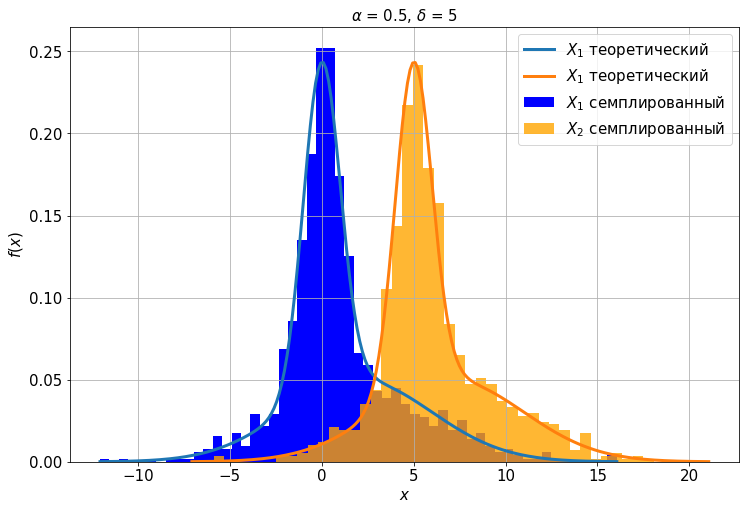

In [63]:
_, _ = wilcoxon_stud([0.5], [5], 'plot')

### Зависимость мощности от $\delta$

In [78]:
deltas = np.linspace(0, 2, 100)
value = []
k = 100
for delta in tqdm(deltas):
    rejects = 0
    for i in range(k):
        _, rjct = wilcoxon_stud([0.5], [delta], '')
        rejects += rjct
    value.append(rejects/k)


100%|██████████| 100/100 [13:45<00:00,  7.06s/it]


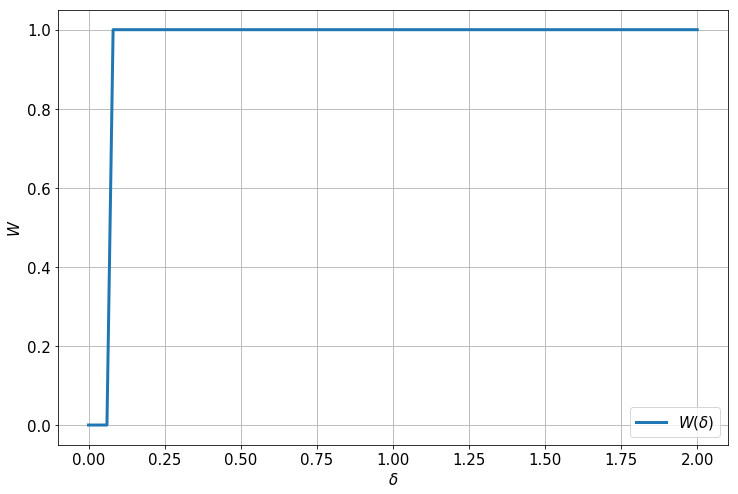

In [145]:
plt.plot(deltas, [i * 1000 for i in value], label=r'$W(\delta)$')
plt.xlabel(r"$\delta$")
plt.ylabel(r"$W$")
plt.legend(loc="best")
plt.grid()
plt.show()

При достаточно большом размере сгенерированных данных ($n = 1000$), мощность становится единицей почти сразу. Она меньше единицы только при совсем малых $\delta$, где она равна нулю, а это значит, что мы отклоняем основную гипотезу почти всегда правильно, либо при малых $\delta$ все время ошибаемся.

Посмотрим теперь при маленьком размере данных $n = 50$:

In [148]:
# Здесь надо поменять n в wilcoxon_stud
deltas = np.linspace(0, 2, 100)
value = []
k = 100
for delta in tqdm(deltas):
    rejects = 0
    for i in range(k):
        _, rjct = wilcoxon_stud([0.5], [delta], '')
        rejects += rjct
    value.append(rejects/k)


100%|██████████| 100/100 [00:42<00:00,  2.48it/s]


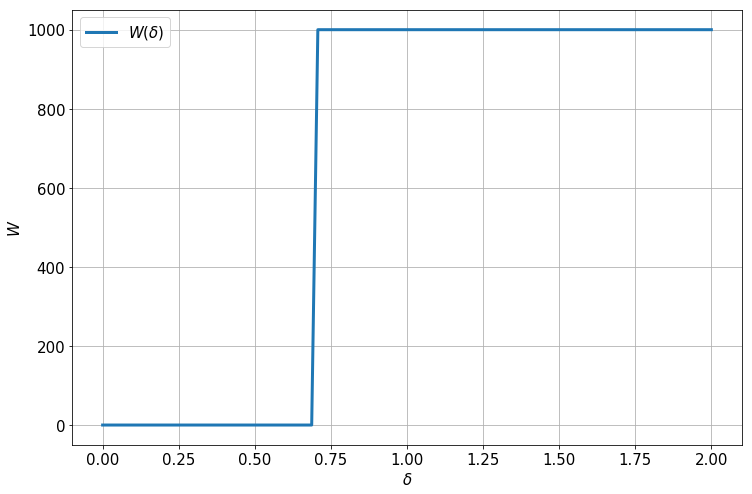

In [149]:
plt.plot(deltas, [i * 1000 for i in value], label=r'$W(\delta)$')
plt.xlabel(r"$\delta$")
plt.ylabel(r"$W$")
plt.legend(loc="best")
plt.grid()
plt.show()

Как видно из графика, при малых размерах данных при $\delta > 0.7$ также все хорошо. То есть, критерий хорошо работает и при малых размера данных, но с увеличением параметра сдвига.

### Консервативность критерия

In [81]:
deltas = np.linspace(0.01, 0.2, 19)
res, _ = wilcoxon_stud([0.5], deltas, '')

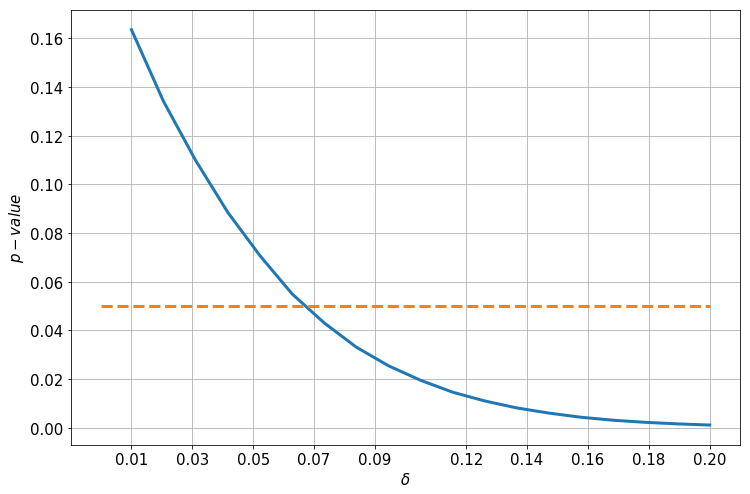

In [97]:
plt.plot(deltas, res, label=r'$p-value(\delta)$')
plt.plot([0,0.2], [0.05, 0.05], ls='--')
plt.xlabel("$\delta$")
plt.ylabel(r"$p-value$")
plt.xticks([round(i,2) for i in deltas[::2]])
plt.grid()
plt.show()

Видно, что при $\delta > 0.07$,значение $p-value$ всегда меньше уровня значимости $\alpha = 0.05$. Значит мы не отвергаем основную гипотезу только при совсем маленьких сдвигах. То есть, критерий хорошо различает эти 2 распределения.

### Зависимость от $\alpha$ и $\delta$

In [135]:
alphas = [0, 0.125, 0.25, 0.5, 0.75, 0.875, 0.9,1]
deltas = np.linspace(0.01, 0.2, 19)
resu, _ = wilcoxon_stud(alphas, deltas, '')

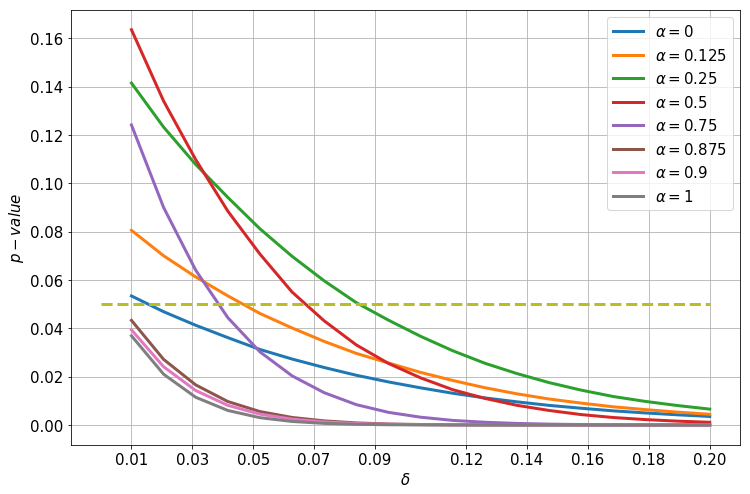

In [136]:
for i, alpha in enumerate(alphas):
    plt.plot(deltas, resu[i*len(deltas):i*len(deltas) + len(deltas)], label=r'$\alpha = $' + str(alpha))

plt.plot([0,0.2], [0.05, 0.05], ls='--')
plt.xlabel(r"$\delta$")
plt.ylabel(r"$p-value$")
plt.legend(loc="best")
plt.xticks([round(i,2) for i in deltas[::2]])
plt.grid()
plt.show()

Из графиков видно, что тренд, который мы наблюдали выше для $\alpha = 0.5$ сохраняется и для других значений этого параметра. Также, можно заметить, что при приюлижении параматра к нулю и единице вся кривая лежит под линией $p-value = 0.05$. Это соответствует тому, когда одно из слогаемых в пересечении зануляется. 

## Вывод

Получается, что критерий Уилкоксона отлично различает распределения. Он правильно определяет почти всегда, не считая совсем малых $\delta$, при которых он точно ошибается.